In [48]:
from psaw import PushshiftAPI
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np

In [2]:
api = PushshiftAPI()      #api usada para puxar comentários do reddit

In [ ]:
start_epoch=int(datetime(2019, 1, 1).timestamp())

scraping = pd.DataFrame(api.search_comments(after=start_epoch,          #comentários a partir de 2019
                        subreddit='bitcoin',                            #do subreddit /r/bitcoin
                        filter=['body', 'date', 'score']                #com data, número de votos e corpo do texto
                        ))
scraping = scraping.drop(['created', 'd_'], axis = 1)

scraping['created_utc'] = pd.to_datetime(scraping['created_utc'],unit='s') 
scraping = scraping.sort_values(by='created_utc')                       #organizados em data

In [ ]:
scraping['TBPolarity'] = pd.Series(dtype='float')                       #criando colunas
scraping['TBSubjectivity'] = pd.Series(dtype='float')

def textblob_pol(body):
    
    return TextBlob(body).sentiment.polarity                            #definindo funções para trabalhar com apply

def textblob_sub(body):
    
    return TextBlob(body).sentiment.subjectivity

scraping['TBPolarity'] = scraping['body'].apply(textblob_pol)           #função de positividade do comentário

scraping['TBSubjectivity'] = scraping['body'].apply(textblob_sub)       #subjetividade

scraping.to_pickle('dados_bitcoin.pkl')                                 #gerando o arquivo utilizado no trabalho

In [134]:
base = pd.read_pickle('dadoscorretos.pkl')                              #abrindo ele

base['score']=base['score'].abs()                                       #tomando votos em módulo como indicação de importância (por hipótese)
base['dia'] = pd.to_datetime(base['created_utc'].dt.date)               #organizando

base['weight'] = base['score']/base.groupby('dia')['score'].transform('sum') #dando peso para comentários se baseando no total de votos do dia
base['value']=base['TBPolarity']*base['weight']                         #valor que cada comentário tem para o sentimento geral do dia

In [81]:
preço_btc = pd.read_csv('btcusd.csv', skiprows=1).sort_values(by='Date')   #dados do bitcoin extraídos do cryptodatadownload.com

In [83]:
preço2019 = preço_btc[(pd.to_datetime(preço_btc['Date']).dt.year >= 2019)] #extraindo dados a partir de 2019
preço2019['Date']=pd.to_datetime(preço2019['Date'])                     #organizando

In [67]:
agg = base.set_index('created_utc').groupby(pd.Grouper(freq='D')).sum()

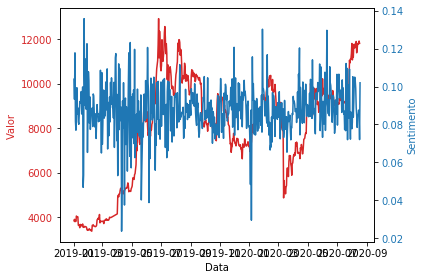

In [137]:
fig, ax1 = plt.subplots()
                                                    #GRÁFICO ALEATÓRIO, DESNECESSÁRIO
color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Valor', color=color)
ax1.plot(preço2019['Date'], preço2019['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Sentimento', color=color) 
ax2.plot(agg['value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [158]:
reddcorr = pd.merge(left=preço2019, left_on='Date',                     #pegando dias onde temos ambos os dados
         right=agg, right_on='created_utc')

In [159]:
def commentcorr(dado1, dado2):                                          #função que avalia o melhor número de dias de lag
    dummy=0                                                         #através da correlação entre os dados extraídos e os dados do btc
    max = 0                                                         #dado 1 começa a partir da i+1-ésima, logo é o dado que queremos prever
    for i in range(15):
        if i == 7:
            print("Lag de maior correlação:", max, " dias atrás")
            return 
        k=i+1
        h=i-7
        if i==0:
            print("Correlação com comentários do dia anterior:", np.corrcoef(dado1[k:h], dado2[:-8])[0][1])
        else:
            print("Correlação com comentários de ", 1+i, " dias atrás:", np.corrcoef(dado1[k:h], dado2[:-8])[0][1])
        if np.corrcoef(dado1[k:h], dado2[:-8])[0][1]>dummy:
            dummy = np.corrcoef(dado1[k:h], dado2[:-8])[0][1]
            max=i+1

In [160]:
commentcorr(reddcorr['Close'], reddcorr['value'])                                #aplicando a função à base de comentários do reddit

Correlação com comentários do dia anterior: 0.0368245830225779
Correlação com comentários de  2  dias atrás: 0.03860449409260005
Correlação com comentários de  3  dias atrás: 0.04205005267600763
Correlação com comentários de  4  dias atrás: 0.03604325828316604
Correlação com comentários de  5  dias atrás: 0.028584474005855818
Correlação com comentários de  6  dias atrás: 0.030188268328582384
Correlação com comentários de  7  dias atrás: 0.028792405064350494
Lag de maior correlação: 3  dias atrás


In [ ]:
dado = pd.read_csv('market_analysis_news.csv')                       #notícias extraídas por scraping do site cointelegraph.com

In [ ]:
dado['TBPolarity'] = pd.Series(dtype='float')
dado['TBSubjectivity'] = pd.Series(dtype='float')

def textblob_pol(body):
    
    return TextBlob(body).sentiment.polarity                         #aplicando o processo feito com os comentários do reddit

def textblob_sub(body):
    
    return TextBlob(body).sentiment.subjectivity

dado['TBPolarity'] = dado['Content'].apply(textblob_pol)

dado['TBSubjectivity'] = dado['Content'].apply(textblob_sub)

dado.to_pickle('noticias.pkl')

In [151]:
news = pd.read_pickle('noticias.pkl')

news['Date'] = pd.to_datetime(news['Date'])
news=news.loc[(news['Date']> '2018-12-31') & (news['Date']< '2020-08-19')]     #mesma coisa     

news['weight'] = news['Views']/news.groupby('Date')['Views'].transform('sum')
news['value']=news['TBPolarity']*news['weight']

In [152]:
newsagg = news.set_index('Date').groupby(pd.Grouper(freq='D')).sum()

In [169]:
newsagg.reset_index(inplace=True)#tomando o índice original para uma operação a seguir, pode ser removido se trocarmos o for por outro método
newsagg['dummy'] = ''             #apenas utilizado no for

In [154]:
for i in range(587):                                                  #triste
    if newsagg['value'][i] != 0:                                      #esse for é utilizado pra fazer o decay de notícias, assim não temos
        newsagg.loc[i, 'dummy'] = 0                                   #dias com valor nulo de sentimento de notícias relacionadas a bitcoin.
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 0):   #Basicamente, ele checa se o dia anterior teve notícias, e se não teve
        newsagg.loc[i, 'dummy'] = 1                                   #ele vê quantos dias atrás houveram notícias através do dummy.
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 1):   #Note que o método depende do índice, logo devemos tirar o índice de
        newsagg.loc[i, 'dummy'] = 2                                   #data.
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 2):   #Para alterar, basta encontrar outra maneira de saber quantos dias 
        newsagg.loc[i, 'dummy'] = 3                                   #atrás houve a última notícia de modo preciso, para poder operar
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 3):   #o decaimento da importância do sentimento. 
        newsagg.loc[i, 'dummy'] = 4
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 4):   #A lógica para o decaimento é a seguinte: consideramos que em um dia
        newsagg.loc[i, 'dummy'] = 5                                   #sem notícias, a última notícia postada é a mais importante, descontada
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 5):   #pelo tempo. Ao surgir uma nova, a anterior se torna irrelevante.
        newsagg.loc[i, 'dummy'] = 6
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 6):
        newsagg.loc[i, 'dummy'] = 7
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 7):
        newsagg.loc[i, 'dummy'] = 8
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 8):
        newsagg.loc[i, 'dummy'] = 9
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 9):
        newsagg.loc[i, 'dummy'] = 10
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 10):
        newsagg.loc[i, 'dummy'] = 11
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 11):
        newsagg.loc[i, 'dummy'] = 12
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 12):
        newsagg.loc[i, 'dummy'] = 13
    else:
        newsagg.loc[i, 'dummy'] = 'idk'

In [155]:
newsagg['value'] = newsagg['value'].replace(to_replace=0, method='ffill')*3/(3+newsagg['dummy'])
#já sabendo o número de dias sem notícias, preenchemos os valores e descontamos com uma função inversa (arbitrária)

In [166]:
corrnoticias = pd.merge(left=preço2019, left_on='Date',
         right=newsagg, right_on='Date')

In [167]:
def newscorr(dado1, dado2):                                          #função que avalia o melhor número de dias de lag
    dummy=0                                                         #através da correlação entre os dados extraídos e os dados do btc
    max = 0                                                         #dado 1 começa a partir da i+1-ésima, logo é o dado que queremos prever
    for i in range(15):
        if i == 7:
            print("Lag de maior correlação:", max, " dias atrás")
            return 
        k=i+1
        h=i-7
        if i==0:
            print("Correlação com notícias do dia anterior:", np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1])
        else:
            print("Correlação com notícias de ", 1+i, " dias atrás:", np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1])
        if np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1]>dummy:
            dummy = np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1]
            max=i+1

In [168]:
newscorr(corrnoticias['Close'], corrnoticias['value'])

Correlação com notícias do dia anterior: 0.14962241229597759
Correlação com notícias de  2  dias atrás: 0.1493440980771414
Correlação com notícias de  3  dias atrás: 0.1486914603975128
Correlação com notícias de  4  dias atrás: 0.14336066070143016
Correlação com notícias de  5  dias atrás: 0.1404012193759254
Correlação com notícias de  6  dias atrás: 0.12697821248377938
Correlação com notícias de  7  dias atrás: 0.12336667440814586
Lag de maior correlação: 1  dias atrás
